# Quantum Machine Learning
## Day 2: Visualization of Quantum Advantages

### Group Members:

- Philipp Fukas
- Christopher Gundler
- Farina Kock
- Jonas Rebstadt
- Christoph Stenkamp

In [1]:
%matplotlib notebook

from collections import namedtuple
import csv
import re

from IPython.display import display, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [2]:
with open('algorithms.csv', 'r') as input_file:
    algorithms = [{k: v for k, v in row.items()} for row in csv.DictReader(input_file, skipinitialspace=True)]

In [3]:
MATH_MODULE = __import__('math')
ALLOWED_FUNCTIONS = {**{name: getattr(MATH_MODULE, name) for name in dir(MATH_MODULE) if name[0] != '_'}, **{'abs': abs}}
    
class Expression:
    def __init__(self, expression):
        simplified = re.sub("O\((.+)\)", "\\1", expression)
        simplified = re.sub("Theta\((.+)\)", "\\1", expression)
        simplified = simplified.replace("N", "n")
        
        n_pos = simplified.find('n')
        if n_pos < len(simplified)-1 and simplified[n_pos+1].isnumeric():
            simplified = simplified.replace('n','n*')
        if n_pos > 0 and simplified[n_pos-1].isnumeric():
            simplified = simplified.replace('n','*n')
            
        self.expression = simplified
    
    def evalfunc(self, expression_python):
        return int(eval(
                expression_python,
                {
                    "__builtins__" : None
                }, 
                ALLOWED_FUNCTIONS
            ))
    
    def execute(self, n):
        expression_python = self.expression.replace('n', str(n))
        try:
            return self.evalfunc(expression_python)
        except OverflowError:
            raise OverflowError("Unable to evaluate '{}' due to its size.".format(expression_python))
        except ValueError:
            raise ValueError("Unable to execute expression {} with {}.".format(self.expression, n))
        except SyntaxError:
            haderror = False
            for factor in expression_python.split(" "):
                try:
                    self.evalfunc(factor)
                except SyntaxError:
                    haderror = True
            if not haderror:
                return self.evalfunc("*".join(expression_python.split(" ")))
                

TypeError: 'NoneType' object is not subscriptable

<IPython.core.display.Javascript object>


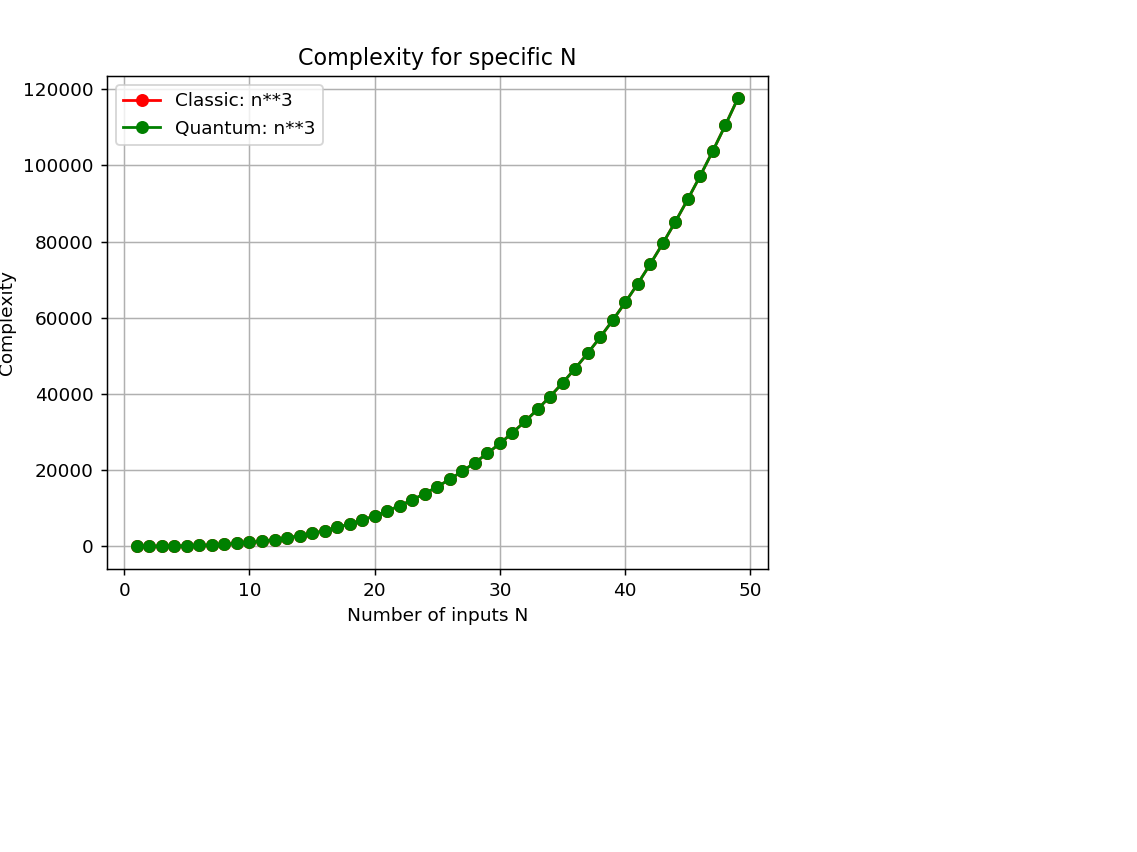

In [4]:
Graph = namedtuple('Graph', ['data', 'label', 'style', 'marker'])

# Constants for different modes.
COMPLEXITY = "Absolute complexity"
DIFFERENCE = "Difference"
RATIO = "Ratio"

def generate_plot(graphs, x_values, title, ylabel):
    fig, ax = plt.subplots()
    for graph in graphs:
        ax.plot(x_values, graph.data, graph.style, label=graph.label, marker=graph.marker)

    ax.set(
        xlabel='Number of inputs N', 
        ylabel=ylabel,
        title=title
    )

    ax.grid()
    ax.legend()
    plt.plot()

# Dict of GUI elements  
ui = {
    "algorithm": widgets.Dropdown(
        options=["Enter manually..."]+[i['name'] for i in algorithms],
        value="Enter manually...",
        description='Algorithm from https://math.nist.gov/quantum/zoo/',
        disabled=False,
    ),
    "text_complexity_quantum": widgets.Text(
        value='O(n ** 3)',
        placeholder='Please enter O(...).',
        description='Quantum complexity:',
        disabled=False
    ),
    "text_complexity_normal": widgets.Text(
        value='O(2 ** n)',
        placeholder='Please enter O(...).',
        description='Classic complexity:',
        disabled=False
    ),
    "text_min_range": widgets.Text(
        value='1',
        placeholder='Please enter the minimal element to be calculated.',
        description='Min range:',
        disabled=False
    ),
    "text_max_range": widgets.Text(
        value='16',
        placeholder='Please enter the maximal element to be calculated.',
        description='Max range:',
        disabled=False
    ),
    "description_coarse_speedup": widgets.Label(
        value='Coarse Speedup:',
        description='Coarse Speedup:'
    ),
    "text_coarse_speedup": widgets.Label(
        value='',
        description='Coarse Speedup:'
    ),
    "radio_buttons_for_y_scale": widgets.RadioButtons(
        options=[COMPLEXITY, DIFFERENCE, RATIO],
        description='Y-Scale:',
        disabled=False
    ),
    "button_calculate": widgets.Button(
        description='Calculate',
        disabled=False,
        button_style='success',
        tooltip='Calculate value',
        icon='check'
    ),
    "button_reset": widgets.Button(
        description='Reset',
        disabled=False,
        button_style='danger',
        tooltip='Reset',
        icon=''
    )
}

# The layout hierarchy
layout = widgets.VBox([
    widgets.HBox([
       widgets.VBox([
           ui['algorithm'],
            widgets.HBox([
               widgets.VBox([
                   ui['description_coarse_speedup'],
               ]),
                widgets.VBox([
                    ui['text_coarse_speedup'],
                ])
            ]),
           ui['text_complexity_quantum'],
           ui['text_complexity_normal'],
           ui['text_min_range'],
           ui['text_max_range']
       ]),
        widgets.VBox([
            ui['radio_buttons_for_y_scale'],
        ])
    ]),
    widgets.HBox([
       widgets.VBox([
           ui['button_calculate'],
       ]),
        widgets.VBox([
            ui['button_reset'],
        ])
    ])
])

# Calculate the values and plot it.
def on_calculate(_):
    expression_classic = Expression(ui['text_complexity_normal'].value)    
    expression_quantum = Expression(ui['text_complexity_quantum'].value)
    
    try:
        min_value = int(ui['text_min_range'].value)
        max_value = int(ui['text_max_range'].value)
    except:
        print("Invalid range! Please correct!")
        return
    
    values = [i for i in range(min_value, max_value)]
    values_classic = [expression_classic.execute(x) for x in values]
    values_quantum = [expression_quantum.execute(x) for x in values]
    
    if ui['radio_buttons_for_y_scale'].value == COMPLEXITY:
        generate_plot([
            Graph(values_classic, label="Classic: {}".format(ui['text_complexity_normal'].value), style="r", marker="o"),
            Graph(values_quantum, label="Quantum: {}".format(ui['text_complexity_quantum'].value), style="g", marker="o")
        ], values, "Complexity for specific N", "Complexity")
    elif ui['radio_buttons_for_y_scale'].value == DIFFERENCE:
        generate_plot([
            Graph([c - q for (c, q) in zip(values_classic, values_quantum)], label="Difference (Positive: 'Classic' takes more time)", style="g", marker="o")
        ], values, "Difference", "Difference")
    elif ui['radio_buttons_for_y_scale'].value == RATIO:
        generate_plot([
            Graph([c / q for (c, q) in zip(values_classic, values_quantum)], label="Ratio", style="g", marker="o")
        ], values, "Ratio", "Ratio")

# Reset the current view
def on_reset(_):
    clear_output()
    display(layout)

ui["button_calculate"].on_click(on_calculate)
ui["button_reset"].on_click(on_reset)


def on_dropdown_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        on_select_algo(change['new'])
        
def on_select_algo(selected):
    ui["text_complexity_quantum"].disabled = selected != 'Enter manually...'
    ui["text_complexity_normal"].disabled = selected != 'Enter manually...'
    if selected != 'Enter manually...':
        selected_algo = algorithms[[i['name'] for i in algorithms].index(selected)]
        ui["text_coarse_speedup"].value = selected_algo["speedup_coarse"]
        
        if selected_algo["assumed_quantum_runtime"] != '':
            ui["text_complexity_quantum"].value = selected_algo["assumed_quantum_runtime"]
        else:
            ui["text_complexity_quantum"].disabled = False
            ui["text_complexity_quantum"].value = ''
            
        if selected_algo["assumed_classical_runtime"] != '':
            ui["text_complexity_normal"].value = selected_algo["assumed_classical_runtime"]
        else:
            ui["text_complexity_normal"].disabled = False
            ui["text_complexity_normal"].value = ''
            
        if selected_algo["assumed_quantum_runtime"] == '' and selected_algo["assumed_classical_runtime"] == '':
            ui['radio_buttons_for_y_scale'].value = RATIO
        elif selected_algo["assumed_quantum_runtime"] != '' and selected_algo["assumed_classical_runtime"] != '':
            ui['radio_buttons_for_y_scale'].value = COMPLEXITY
        
        if selected_algo['meaningful_domain_min']:
            ui["text_min_range"].value = selected_algo['meaningful_domain_min']
        else:
            ui["text_min_range"].value = "1"
            
        if selected_algo['meaningful_domain_max']:
            ui["text_max_range"].value = selected_algo['meaningful_domain_max']
        else:
            ui["text_max_range"].value = "50"
    else:
        ui["text_coarse_speedup"].value = ""
        ui["text_min_range"].value = "1"
        ui["text_max_range"].value = "50"
            
ui["algorithm"].observe(on_dropdown_change)


display(layout)